In [8]:
#!/usr/local/bin/python3
import os
from time import time
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import randint as sp_randint
from scipy import interp
from drivendata_validator import DrivenDataValidator
from tpot import TPOTRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, log_loss, mean_absolute_error, make_scorer

import warnings
warnings.filterwarnings("ignore")

In [9]:
def pre_process_train_test_data(train, test, label_var, exclude_scaling):
    labels = np.ravel(train[label_var])
    train = pd.get_dummies(train.drop(label_var, axis=1))
    test = pd.get_dummies(test)

    # match test set and training set columns
    to_drop = np.setdiff1d(test.columns, train.columns)
    to_add = np.setdiff1d(train.columns, test.columns)

    test.drop(to_drop, axis=1, inplace=True)
    test = test.assign(**{c: 0 for c in to_add})

    test_indices = test.index
    train_indices = train.index
    train_test = pd.concat([train, test])
    train_test.sort_values(['year', 'weekofyear'], inplace=True)
    train_test.interpolate(method='linear', inplace=True)

    print("Shapes before transformation")
    print("Train : ", train.shape)
    print("Test : ", test.shape)
    print("Train + Test : ", train_test.shape)

    numeric_vals = train_test.select_dtypes(include=['int64', 'float64'])
    numeric_vals = numeric_vals.loc[:, [x for x in list(numeric_vals.columns.values) if x not in exclude_scaling]]
    scaler = StandardScaler()
    train_test[numeric_vals.columns] = scaler.fit_transform(numeric_vals)

    train = train_test.loc[train_indices, :]
    test = train_test.loc[test_indices, :]

    train[label_var] = labels

    print("Shapes after transformation")
    print("Train : ", train.shape)
    print("Test : ",  test.shape)

    return train, test

In [10]:
## define data paths
DATA_DIR = '../data'
data_paths = {'train_x': os.path.join(DATA_DIR, 'dengue_features_train.csv'),
              'train_y': os.path.join(DATA_DIR, 'dengue_labels_train.csv'),
               'test_x':  os.path.join(DATA_DIR, 'dengue_features_test.csv')}

## load training data
X_train = pd.read_csv(data_paths['train_x'])
y_train = pd.read_csv(data_paths['train_y'])
X_train.drop(columns='week_start_date', inplace=True)

## load test data
X_test = pd.read_csv(data_paths['test_x'])
X_test.drop(columns='week_start_date', inplace=True)

## Pre-process Data
print("Shapes before transformation")
print("Train : ", X_train.shape)
print("Train Labels : ", y_train.shape)
print("Test : ", X_test.shape)
print("Columns : ", X_train.columns)
train_data = pd.merge(X_train, y_train, on=['city', 'year', 'weekofyear'])
train_data.index = np.arange(0, train_data.shape[0])
X_test.index = np.arange(train_data.shape[0]+1, train_data.shape[0]+X_test.shape[0]+1)

Shapes before transformation
('Train : ', (1456, 23))
('Train Labels : ', (1456, 4))
('Test : ', (416, 23))
('Columns : ', Index([u'city', u'year', u'weekofyear', u'ndvi_ne', u'ndvi_nw', u'ndvi_se',
       u'ndvi_sw', u'precipitation_amt_mm', u'reanalysis_air_temp_k',
       u'reanalysis_avg_temp_k', u'reanalysis_dew_point_temp_k',
       u'reanalysis_max_air_temp_k', u'reanalysis_min_air_temp_k',
       u'reanalysis_precip_amt_kg_per_m2',
       u'reanalysis_relative_humidity_percent',
       u'reanalysis_sat_precip_amt_mm',
       u'reanalysis_specific_humidity_g_per_kg', u'reanalysis_tdtr_k',
       u'station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c', u'station_precip_mm'],
      dtype='object'))


In [11]:
## Rename Variables
train_data = train_data.rename(columns={'precipitation_amt_mm': 'pred_precip', 
                        'reanalysis_air_temp_k': 'pred_temp',
                        'reanalysis_avg_temp_k': 'pred_avg_temp',
                        'reanalysis_dew_point_temp_k': 'pred_dew_temp',
                        'reanalysis_max_air_temp_k': 'pred_max_temp',
                        'reanalysis_min_air_temp_k': 'pred_min_temp',
                        'reanalysis_precip_amt_kg_per_m2': 'pred_precip_vol',
                        'reanalysis_specific_humidity_g_per_kg' : 'pred_spec_humidity',
                        'reanalysis_tdtr_k' : 'pred_temp_rng',
                        'reanalysis_relative_humidity_percent' : 'pred_rel_humidity_per',
                        'reanalysis_sat_precip_amt_mm': 'pred_sat_precip'
                        })
train_data.interpolate(method='linear', inplace=True)

X_test = X_test.rename(columns={'precipitation_amt_mm': 'pred_precip', 
                        'reanalysis_air_temp_k': 'pred_temp',
                        'reanalysis_avg_temp_k': 'pred_avg_temp',
                        'reanalysis_dew_point_temp_k': 'pred_dew_temp',
                        'reanalysis_max_air_temp_k': 'pred_max_temp',
                        'reanalysis_min_air_temp_k': 'pred_min_temp',
                        'reanalysis_precip_amt_kg_per_m2': 'pred_precip_vol',
                        'reanalysis_specific_humidity_g_per_kg' : 'pred_spec_humidity',
                        'reanalysis_tdtr_k' : 'pred_temp_rng',
                        'reanalysis_relative_humidity_percent' : 'pred_rel_humidity_per',
                        'reanalysis_sat_precip_amt_mm': 'pred_sat_precip'
                        })
X_test.interpolate(method='linear', inplace=True)

kelvin_cols = ['pred_temp', 'pred_avg_temp', 'pred_dew_temp', 'pred_max_temp', 'pred_min_temp']
train_data.loc[:, kelvin_cols] = train_data.loc[:, kelvin_cols].copy() - 273.15
X_test.loc[:, kelvin_cols] = X_test.loc[:, kelvin_cols].copy() - 273.15
train_data['log_cases'] = np.log10(train_data.loc[:, 'total_cases'].copy() + 1)
train_data.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,pred_precip,pred_temp,pred_avg_temp,...,pred_sat_precip,pred_spec_humidity,pred_temp_rng,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,log_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,24.422857,24.592857,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,0.698970
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,25.061429,25.292857,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,0.778151
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,25.631429,25.728571,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,0.698970
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,25.837143,26.078571,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,0.602060
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,26.368571,26.514286,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,0.845098


In [12]:
train_data.columns.values

array(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'pred_precip', 'pred_temp', 'pred_avg_temp',
       'pred_dew_temp', 'pred_max_temp', 'pred_min_temp',
       'pred_precip_vol', 'pred_rel_humidity_per', 'pred_sat_precip',
       'pred_spec_humidity', 'pred_temp_rng', 'station_avg_temp_c',
       'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases',
       'log_cases'], dtype=object)

In [13]:
pred_cols = ['pred_precip', 'pred_temp', 'pred_avg_temp',
             'pred_dew_temp', 'pred_max_temp', 'pred_min_temp',
             'pred_temp_rng', 'pred_precip_vol', 'pred_rel_humidity_per',
             'pred_sat_precip', 'pred_spec_humidity']

sta_cols = ['station_avg_temp_c', 'station_min_temp_c', 'station_max_temp_c',
            'station_diur_temp_rng_c', 'station_precip_mm']

veg_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']

loc_cols = ['city', 'year', 'weekofyear']

In [14]:
train_data.loc[:, ['pred_avg_temp', 'station_avg_temp_c']].head()

,pred_avg_temp,station_avg_temp_c
0,24.592857,25.442857
1,25.292857,26.714286
2,25.728571,26.714286
3,26.078571,27.471429
4,26.514286,28.942857


In [15]:
# Check the type of our features. Are there any data inconsistencies?
train_data.dtypes

city                        object
year                         int64
weekofyear                   int64
ndvi_ne                    float64
ndvi_nw                    float64
ndvi_se                    float64
ndvi_sw                    float64
pred_precip                float64
pred_temp                  float64
pred_avg_temp              float64
pred_dew_temp              float64
pred_max_temp              float64
pred_min_temp              float64
pred_precip_vol            float64
pred_rel_humidity_per      float64
pred_sat_precip            float64
pred_spec_humidity         float64
pred_temp_rng              float64
station_avg_temp_c         float64
station_diur_temp_rng_c    float64
station_max_temp_c         float64
station_min_temp_c         float64
station_precip_mm          float64
total_cases                  int64
log_cases                  float64
dtype: object

In [16]:
# Can you check to see if there are any missing values in our data set
train_data.isnull().any()

city                       False
year                       False
weekofyear                 False
ndvi_ne                    False
ndvi_nw                    False
ndvi_se                    False
ndvi_sw                    False
pred_precip                False
pred_temp                  False
pred_avg_temp              False
pred_dew_temp              False
pred_max_temp              False
pred_min_temp              False
pred_precip_vol            False
pred_rel_humidity_per      False
pred_sat_precip            False
pred_spec_humidity         False
pred_temp_rng              False
station_avg_temp_c         False
station_diur_temp_rng_c    False
station_max_temp_c         False
station_min_temp_c         False
station_precip_mm          False
total_cases                False
log_cases                  False
dtype: bool

In [17]:
# Display the statistical overview of the employees
train_data.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,pred_precip,pred_temp,pred_avg_temp,pred_dew_temp,...,pred_sat_precip,pred_spec_humidity,pred_temp_rng,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,log_cases
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,2001.031593,26.503434,0.131490,0.127823,0.203130,0.201963,45.702091,25.547750,26.071723,22.094555,...,45.702091,16.744659,4.900618,27.181438,8.095505,32.446497,22.098043,39.362294,24.675137,1.086626
std,5.408314,15.019437,0.137272,0.119478,0.073781,0.083491,43.651356,1.359878,1.260384,1.525955,...,43.651356,1.540958,3.542762,1.281116,2.127521,1.959090,1.570524,47.285701,43.596000,0.538882
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,21.485714,21.742857,16.492857,...,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000,0.000000
25%,1997.000000,13.750000,0.037400,0.048092,0.154057,0.144455,9.785000,24.507857,25.107143,20.967857,...,9.785000,15.554643,2.328571,26.314286,6.528571,31.100000,21.100000,8.850000,5.000000,0.778151
50%,2002.000000,26.500000,0.115550,0.115926,0.195664,0.190121,38.320000,25.490000,26.135714,22.488571,...,38.320000,17.084286,2.857143,27.400000,7.350000,32.800000,22.200000,24.050000,12.000000,1.113943
75%,2005.000000,39.250000,0.231443,0.213429,0.247461,0.246579,70.227500,26.677500,27.057143,23.307857,...,70.227500,17.976071,7.632143,28.130804,9.603571,33.900000,23.300000,53.900000,28.000000,1.462398
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,29.050000,29.778571,25.300000,...,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000,2.664642


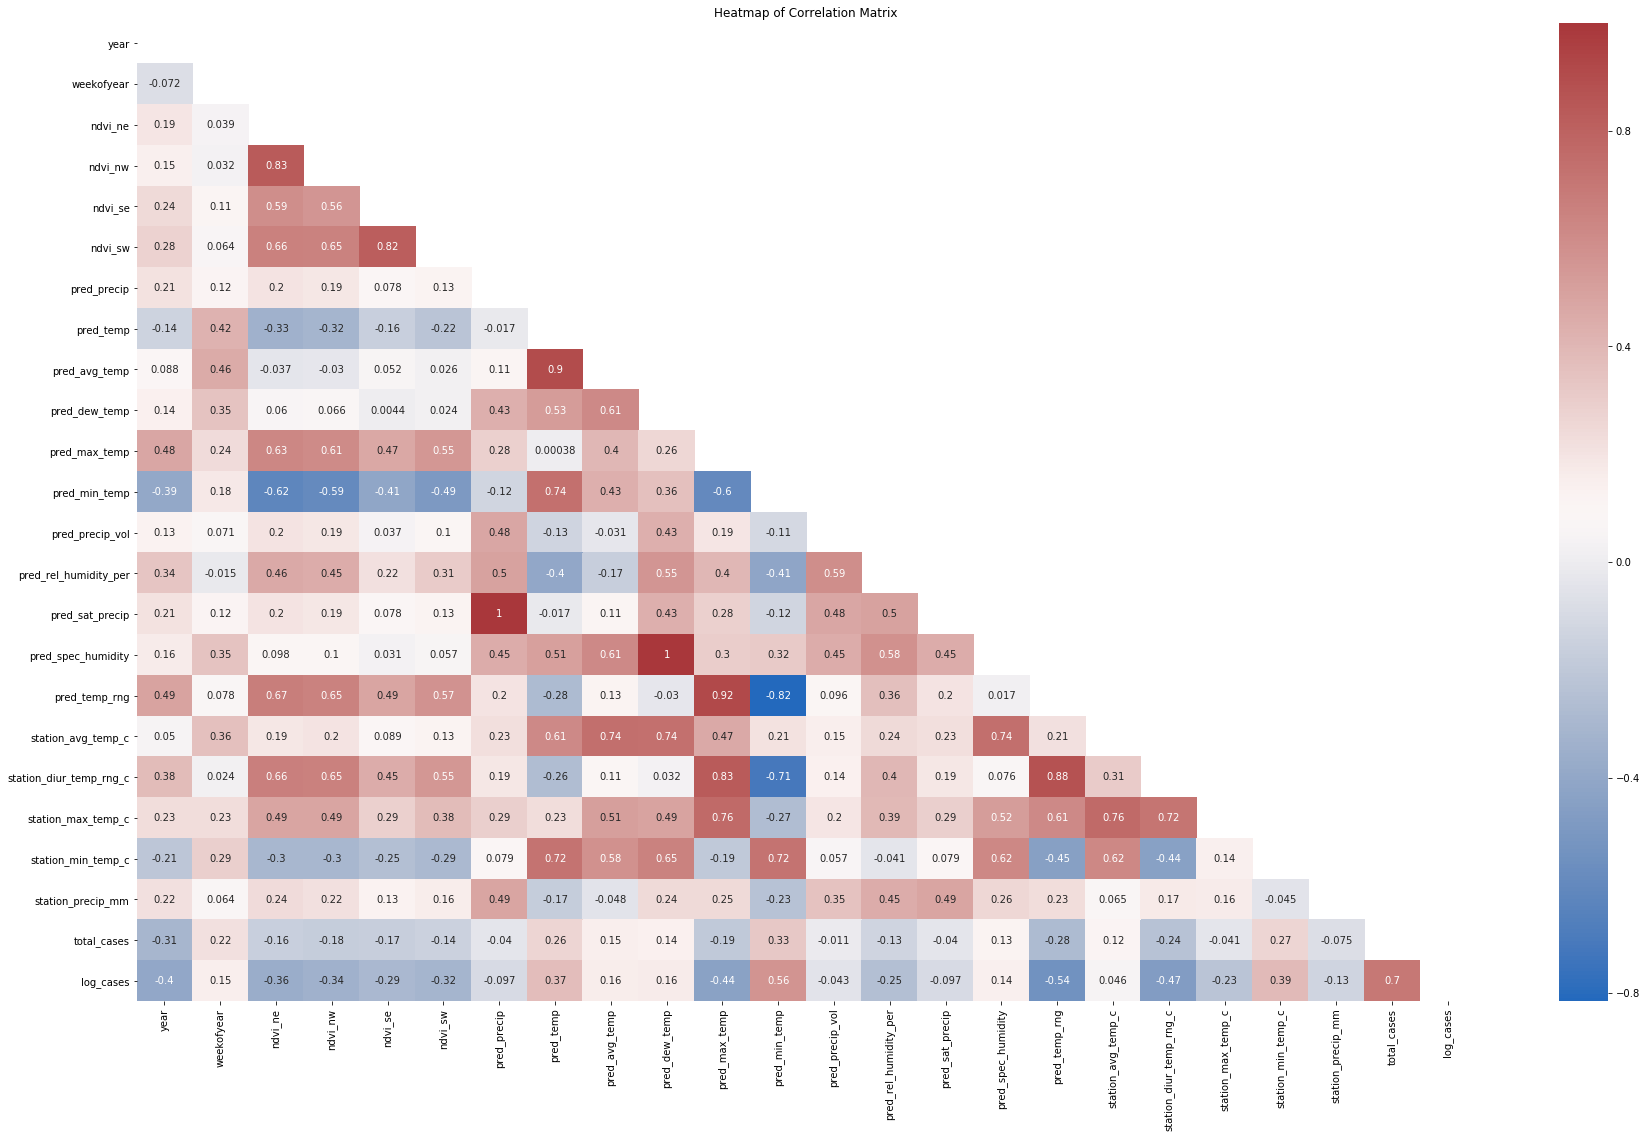

In [44]:
# Create a correlation matrix. What features correlate the most with turnover? What other correlations did you find?
plt.figure(figsize=(30, 18))
corr = train_data.corr()
corr = (corr)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap="vlag", mask=mask, annot=True)
plt.title('Heatmap of Correlation Matrix')
# corr

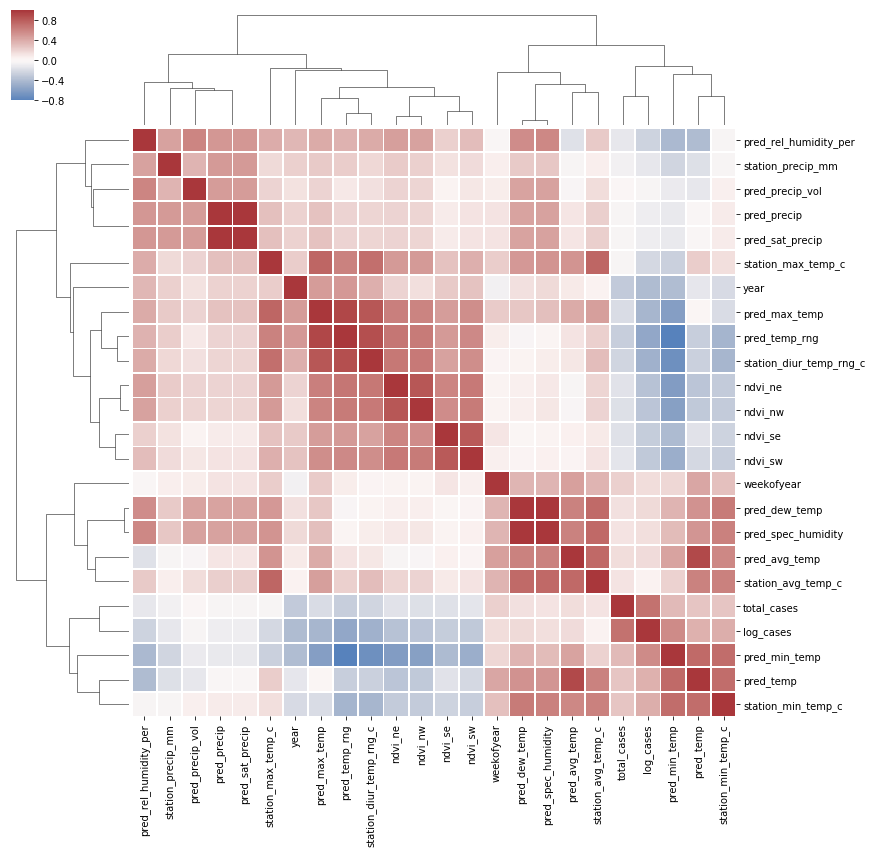

In [19]:
sns.clustermap(corr, center=0, cmap="vlag", linewidths=.75, figsize=(13, 13))

In [ ]:
# pred_sat_precip and pred_precip -- Keep one
# pred_dew_temp and pred_spec_humidity -- Keep one
# pred_avg_temp and pred_temp -- Keep one
# pred_max_temp and pred_temp_rng and station_diur_temp_rng_c
# ndvi_ne and ndvi_nw
# ndvi_se and ndvi_sw

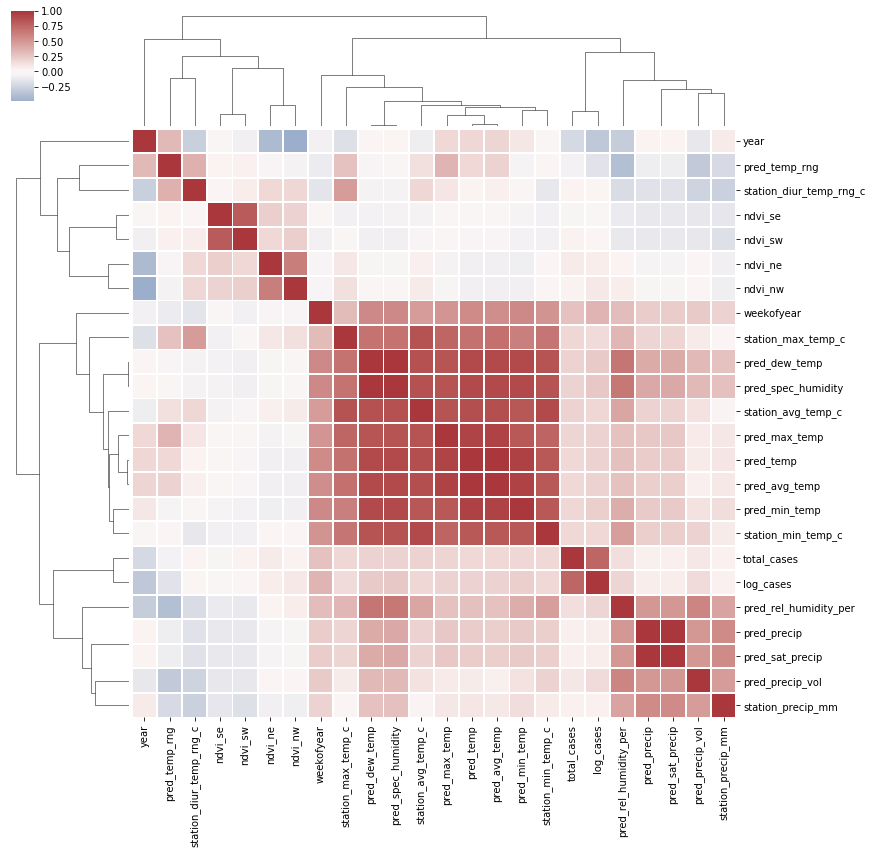

In [21]:
plt.figure(figsize=(12, 10))
train_data_sj = train_data.loc[train_data.city == 'sj', :].copy()
corr_sj = train_data_sj.corr()
corr_sj = (corr_sj)
sns.clustermap(corr_sj, center=0, cmap="vlag", linewidths=.75, figsize=(13, 13))

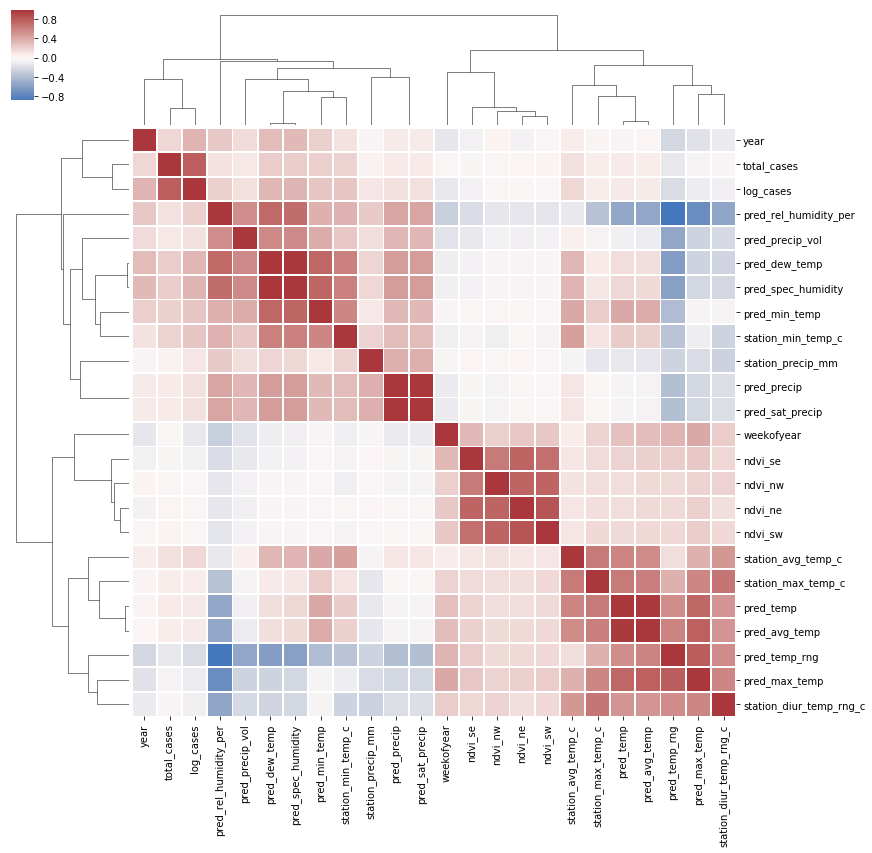

In [22]:
plt.figure(figsize=(12, 10))
train_data_iq = train_data.loc[train_data.city == 'iq', :].copy()
corr_iq = train_data_iq.corr()
corr_iq = (corr_iq)
sns.clustermap(corr_iq, center=0, cmap="vlag", linewidths=.75, figsize=(13, 13))

In [27]:
# pred_sat_precip and pred_precip -- Keep one
# pred_dew_temp and pred_spec_humidity -- Keep one
# pred_avg_temp and pred_temp -- Keep one
# pred_max_temp and pred_temp_rng and station_diur_temp_rng_c -- Keep one



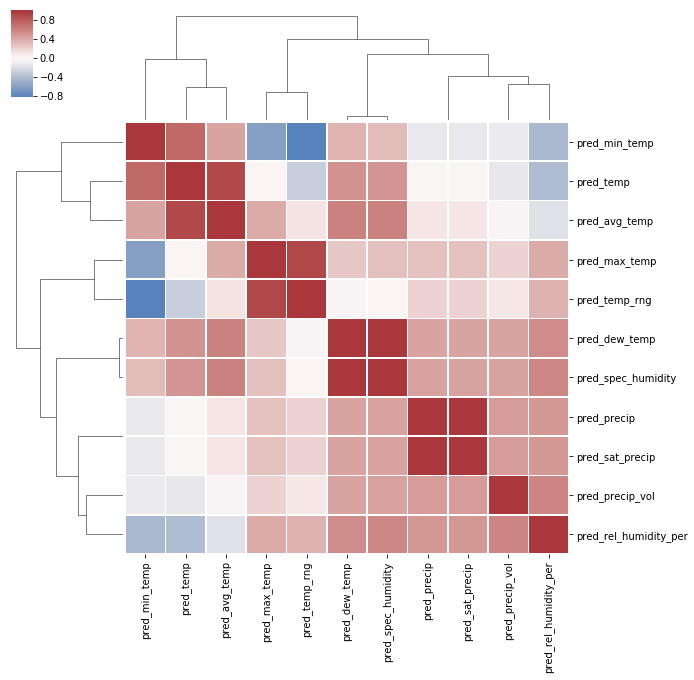

In [32]:
plt.figure(figsize=(12, 10))
train_data_pred = train_data.loc[:, pred_cols].copy()
corr_pred = train_data_pred.corr()
corr_pred = (corr_pred)
sns.clustermap(corr_pred, center=0, cmap="vlag", linewidths=.75, figsize=(10, 10))

In [ ]:
to_drop = ['pred_sat_precip', 'pred_dew_temp', 'pred_temp_rng',
           'pred_avg_temp', 'station_avg_temp_c', 'station_diur_temp_rng_c',
           'ndvi_se', 'ndvi_nw']

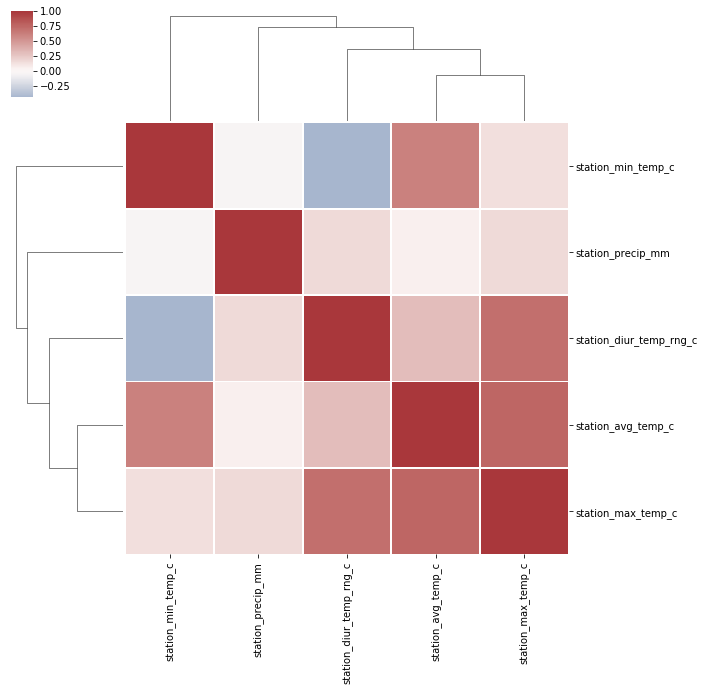

In [34]:
plt.figure(figsize=(12, 10))
train_data_sta = train_data.loc[:, sta_cols].copy()
corr_sta = train_data_sta.corr()
corr_sta = (corr_sta)
sns.clustermap(corr_sta, center=0, cmap="vlag", linewidths=.75, figsize=(10, 10))

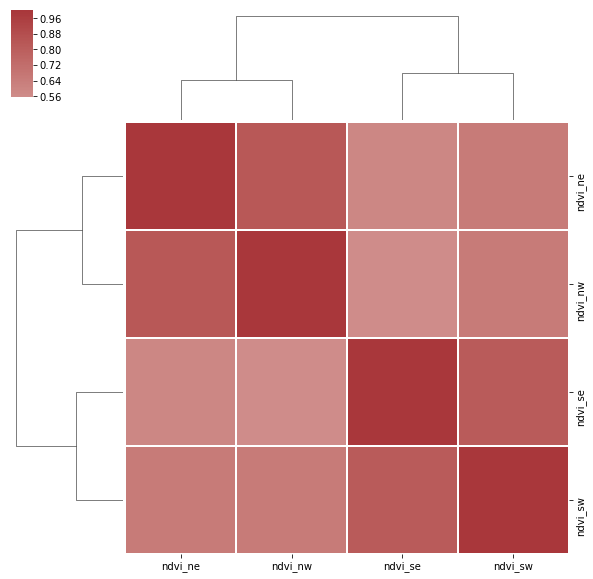

In [35]:
plt.figure(figsize=(12, 10))
train_data_veg = train_data.loc[:, veg_cols].copy()
corr_veg = train_data_veg.corr()
corr_veg = (corr_veg)
sns.clustermap(corr_veg, center=0, cmap="vlag", linewidths=.75, figsize=(10, 10))

In [55]:
to_drop = ['pred_sat_precip', 'pred_dew_temp', 'pred_temp_rng',
           'pred_avg_temp', 'station_avg_temp_c', 'station_diur_temp_rng_c',
           'ndvi_se', 'ndvi_nw', 'pred_max_temp', 'pred_min_temp', 'pred_temp', 'log_cases']
train_data_drop = train_data.drop(to_drop, axis=1)

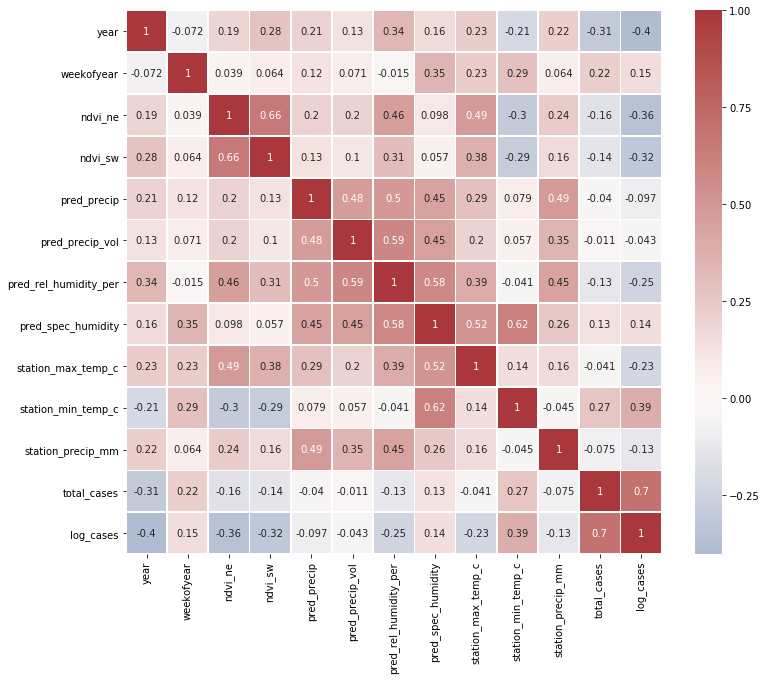

In [46]:
plt.figure(figsize=(12, 10))
corr_drop = train_data_drop.corr()
corr_drop = (corr_drop)
# sns.clustermap(corr_drop, center=0, cmap="vlag", linewidths=.75, figsize=(13, 13))
sns.heatmap(corr_drop, center=0, cmap="vlag", linewidths=.75, annot=True)

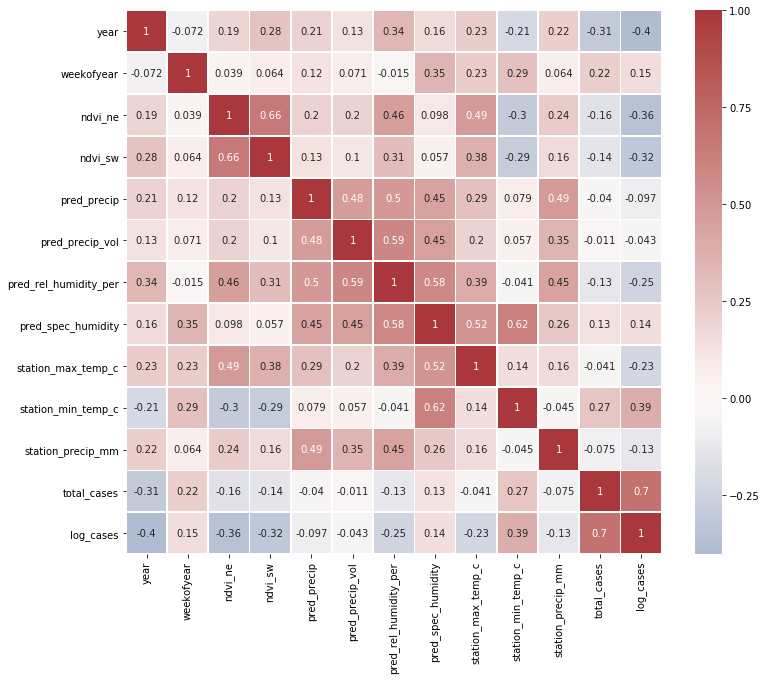

In [51]:
numeric_vals = train_data_drop.select_dtypes(include=['int64', 'float64'])
# numeric_vals = numeric_vals.loc[:, [x for x in list(numeric_vals.columns.values) if x not in exclude_scaling]]
scaler = StandardScaler()
train_data_drop[numeric_vals.columns] = scaler.fit_transform(numeric_vals)
plt.figure(figsize=(12, 10))
corr_drop_scale = train_data_drop.corr()
corr_drop_scale = (corr_drop_scale)
# sns.clustermap(corr_drop, center=0, cmap="vlag", linewidths=.75, figsize=(13, 13))
sns.heatmap(corr_drop_scale, center=0, cmap="vlag", linewidths=.75, annot=True)

In [31]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 10))
# sns.clustermap(corr_sj, center=0, cmap="vlag", linewidths=.75, kwargs={'ax': ax[0]})
# # sns.clustermap(corr_iq, center=0, cmap="vlag", linewidths=.75, ax=ax[1])

In [ ]:
fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    sns.heatmap(df, ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

In [ ]:
# sns.pairplot(train_data, hue="total_cases")

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train_data, y='pred_max_temp', x='station_max_temp_c', hue='log_cases')

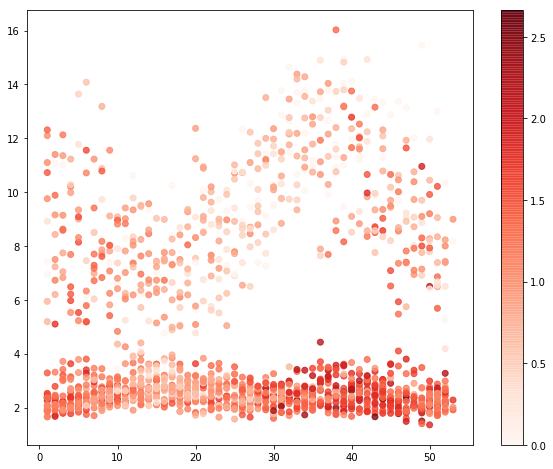

In [56]:
plt.figure(figsize=(10, 8))
plt.scatter(train_data.weekofyear, train_data.pred_temp_rng,
            alpha = .8, c = train_data.log_cases, cmap = 'Reds')
cbar = plt.colorbar()

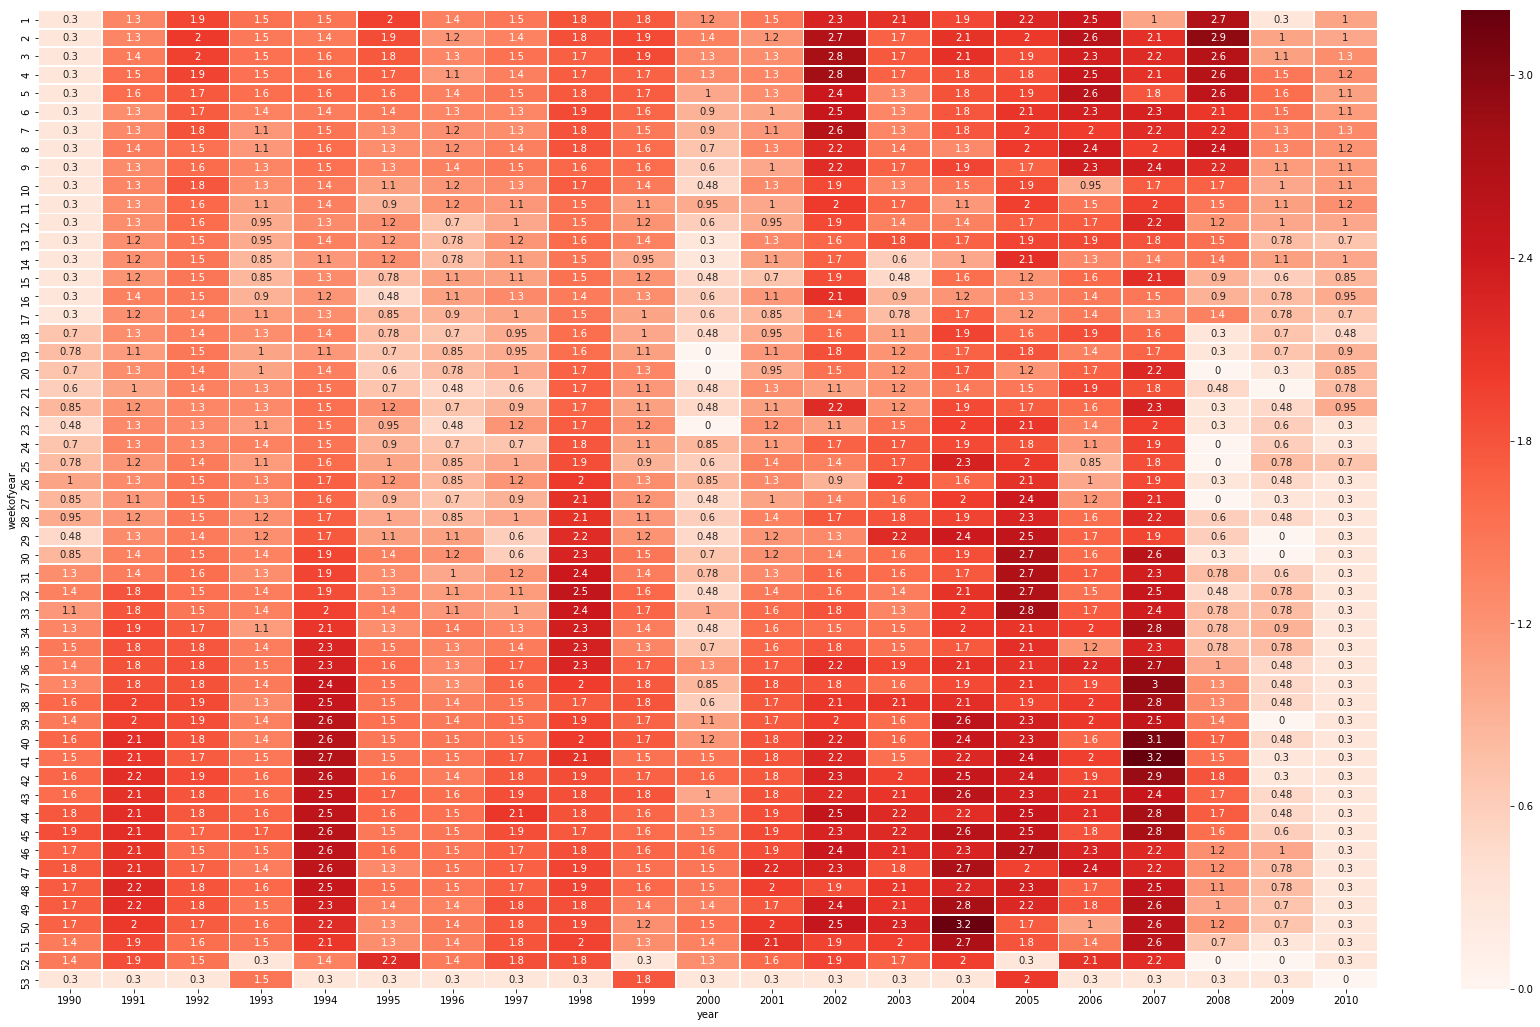

In [72]:
plt.figure(figsize=(30, 18))
train_data_2 = train_data.groupby(['year', 'weekofyear'])['log_cases'].sum().unstack('year').fillna(0.3)
sns.heatmap(train_data_2, cmap="Reds", linewidths=.75, annot=True)

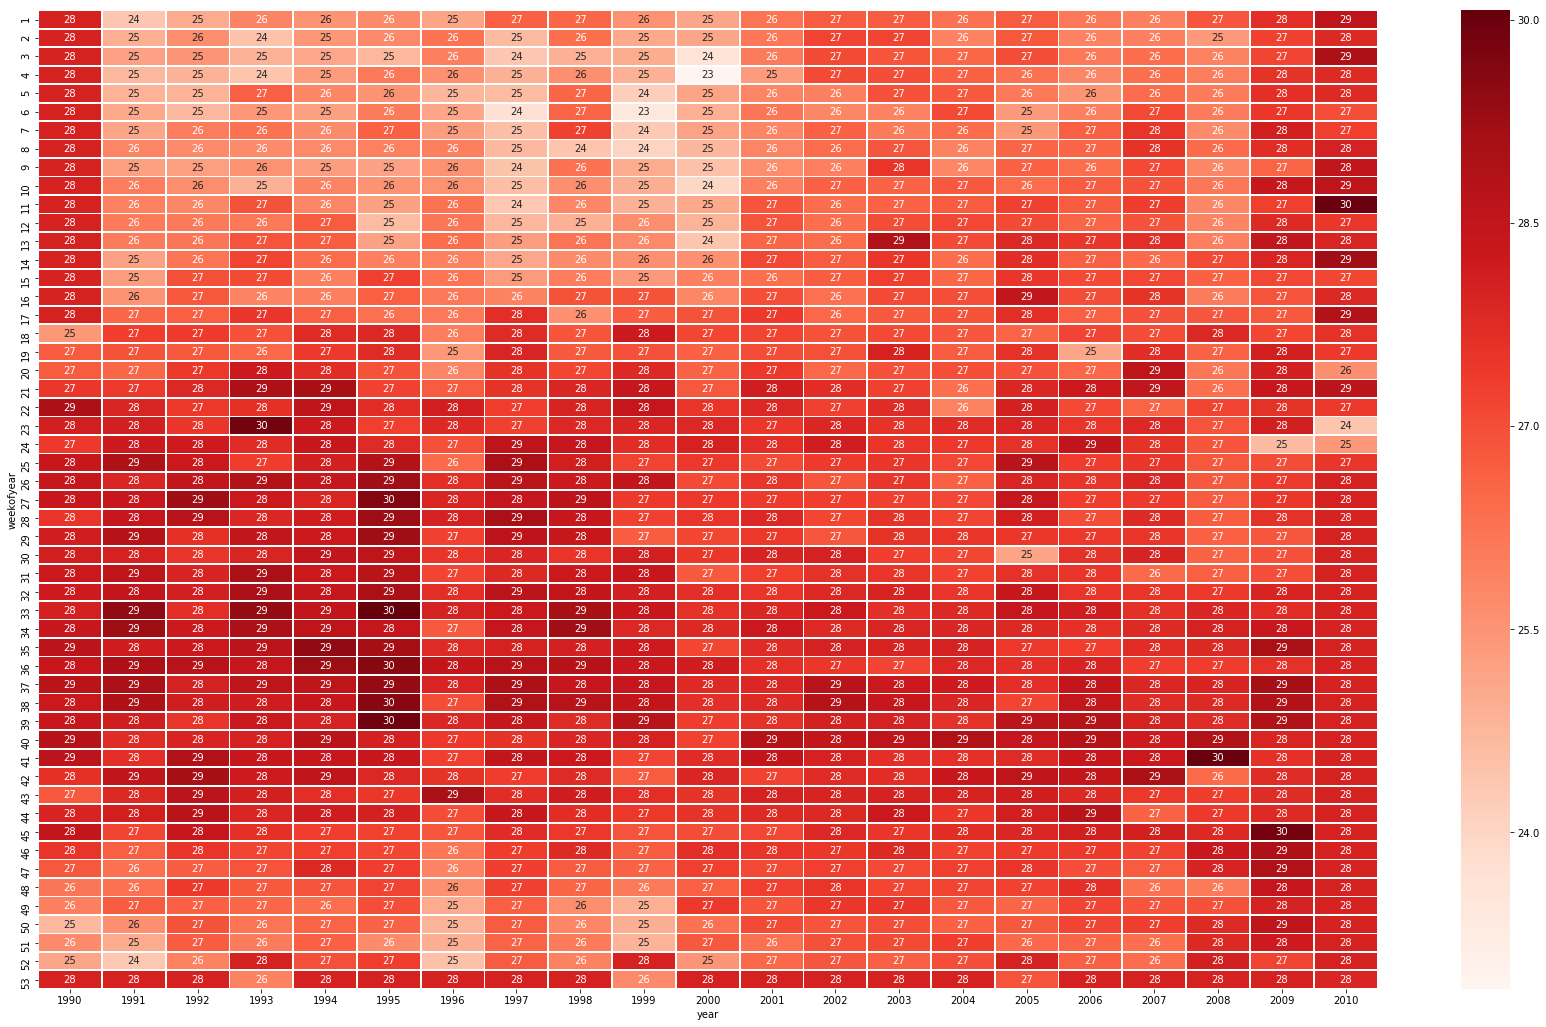

In [70]:
plt.figure(figsize=(30, 18))
train_data_2 = train_data.groupby(['year', 'weekofyear'])['station_avg_temp_c'].mean().unstack('year').fillna(28)
sns.heatmap(train_data_2, cmap="Reds", linewidths=.75, annot=True)

In [73]:
print("Preprocessing Training")
label_var = 'total_cases'
exclude_scaling = ['year']
a_train, a_test = pre_process_train_test_data(train_data_drop, X_test, label_var, exclude_scaling)
X_train = a_train.drop(label_var, axis=1)
y_train = np.ravel(a_train[label_var])

## restructure train data
all_train_data = {'features': X_train,
                  'labels': y_train}

## restructure test data
all_test_data = {'features': a_test}

# ### Cross-validation -- Tune Parameters
X = all_train_data['features'].values.astype(np.float32)
y = all_train_data['labels'].astype(np.int32)
X_test = all_test_data['features'].values.astype(np.float32)

Preprocessing Training
Shapes before transformation
('Train : ', (1456, 13))
('Test : ', (416, 13))
('Train + Test : ', (1872, 13))
Shapes after transformation
('Train : ', (1456, 14))
('Test : ', (416, 13))


In [ ]:
tune_params = 1
if tune_params > 0:
    bestParams = []
    X = all_train_data['features'].values.astype(np.float32)
    y = all_train_data['labels'].astype(np.int32)
    mae_score = make_scorer(mean_absolute_error, greater_is_better=False)
#     pipeline_optimizer = TPOTRegressor(scoring=mae_score, cv=5,
#                                         periodic_checkpoint_folder='tpot_best_models_100',
#                                         n_jobs=2, random_state=42, verbosity=1, memory='auto',
#                                         generations=2, max_eval_time_mins=10)
    
    pipeline_optimizer = TPOTRegressor(scoring=mae_score, cv=10,
                                    periodic_checkpoint_folder='tpot_best_models_100_feat_13',
                                    n_jobs=2, random_state=42, verbosity=1, memory='auto',
                                    generations=100, max_eval_time_mins=10)
    pipeline_optimizer.fit(X, y)
    pipeline_optimizer.export('tpot_best_model_feature_13_gen_100.py')